# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [20]:
import netml
from netml.pparser.parser import PCAP
import pandas as pd
pcap = PCAP('./netflix.pcap')
pcap.pcap2pandas()
df = pcap.df
print(df.shape)
print(df.head(3))
print(df.columns)

(141471, 18)
             datetime                        dns_query dns_resp  \
0 2018-02-11 08:10:00            (fonts.gstatic.com.,)     None   
1 2018-02-11 08:10:00            (fonts.gstatic.com.,)     None   
2 2018-02-11 08:10:00  (googleads.g.doubleclick.net.,)     None   

          ip_dst    ip_dst_int         ip_src    ip_src_int  is_dns  length  \
0  128.93.77.234  2.153598e+09  192.168.43.72  3.232247e+09    True      77   
1  128.93.77.234  2.153598e+09  192.168.43.72  3.232247e+09    True      77   
2  128.93.77.234  2.153598e+09  192.168.43.72  3.232247e+09    True      87   

             mac_dst      mac_dst_int            mac_src      mac_src_int  \
0  a0:ce:c8:0d:2b:a7  176809980013479  e4:ce:8f:01:4c:54  251575813622868   
1  a0:ce:c8:0d:2b:a7  176809980013479  e4:ce:8f:01:4c:54  251575813622868   
2  a0:ce:c8:0d:2b:a7  176809980013479  e4:ce:8f:01:4c:54  251575813622868   

   port_dst  port_src protocol               time time_normed  
0      53.0   55697.0      U

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [21]:

NF_DOMAINS = ["nflxvideo", "netflix", "nflxso", "nflxext"]
pattern = "|".join(NF_DOMAINS)
mask = df['dns_query'].astype(str).str.contains(pattern, na= False, regex = True)
netflix_df = df[mask].copy()
netflix_ip = netflix_df['dns_resp'].dropna().drop_duplicates()
netflix_ip = [netflix_ip.iloc[i][0] for i in range(netflix_ip.shape[0])]
print(netflix_ip)

mask1 = df['ip_src'].isin(netflix_ip)
mask2 = df['ip_dst'].isin(netflix_ip)
netflix_traffic = df[mask1|mask2].copy()
print(netflix_traffic.shape)
netflix_traffic.head(3)


['198.38.120.130', '52.19.39.146', '52.210.19.176', '198.38.120.153', '198.38.120.137', '198.38.120.167', '34.252.77.54', '198.38.120.134', '198.38.120.164', '198.38.120.166', '198.38.120.162', '52.48.148.78', '52.48.8.150', '52.208.128.101', '52.210.133.255']
(138633, 18)


,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
107,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58451.0,TCP,1518358202.903273,2.368591
109,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58452.0,TCP,1518358202.903319,2.368637
110,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58453.0,TCP,1518358202.903415,2.368733


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [22]:
import numpy as np
def df_to_flow_features(df):
    df = df.copy()

    df['flow_id'] = (
        df['ip_src'].astype(str) + '_' +
        df['ip_dst'].astype(str) + '_' +
        df['port_src'].astype(str) + '_' +
        df['port_dst'].astype(str) + '_' +
        df['protocol']
    )

    # Group by flow_id to compute stats
    features = df.groupby('flow_id').apply(lambda g: pd.Series({
        'pkt_count': len(g),
        'total_bytes': g['length'].sum(),
        'mean_pkt_size': g['length'].mean(),
        'std_pkt_size': g['length'].std(),
        'duration': g['time'].max() - g['time'].min(),
        'throughput': g['length'].sum() / (g['time'].max() - g['time'].min())
    }))

    return features.reset_index()
print(netflix_traffic.shape)
netflix_features = df_to_flow_features(netflix_traffic)
netflix_features

(138633, 18)


C:\Users\lwy03\AppData\Local\Temp\ipykernel_14256\2380754679.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features = df.groupby('flow_id').apply(lambda g: pd.Series({


,flow_id,pkt_count,total_bytes,mean_pkt_size,std_pkt_size,duration,throughput
0,192.168.43.72_198.38.120.130_58451.0_443.0_TCP,12,1064,88.666667,50.281631,14.440177,73.68330734450138665197801938
1,192.168.43.72_198.38.120.130_58452.0_443.0_TCP,11,998,90.727273,52.201707,14.442865,69.09986349661234111099148265
2,192.168.43.72_198.38.120.130_58453.0_443.0_TCP,12,1064,88.666667,50.281631,14.437420,73.69737806339359802513191415
3,192.168.43.72_198.38.120.130_58480.0_443.0_TCP,5,342,68.400000,5.366563,17.617088,19.41296995280945409366179019
4,192.168.43.72_198.38.120.134_58496.0_443.0_TCP,52,3826,73.576923,31.025193,61.069260,62.65017784725080998197783959
...,...,...,...,...,...,...,...
105,52.210.19.176_192.168.43.72_443.0_58461.0_TCP,21,2713,129.190476,64.162777,127.623987,21.25775932701428611535228092
106,52.210.19.176_192.168.43.72_443.0_58462.0_TCP,9,1220,135.555556,63.154792,17.102807,71.33331972932864178377268714
107,52.210.19.176_192.168.43.72_443.0_58463.0_TCP,9,1220,135.555556,63.154792,17.102560,71.33434994527135118952952073
108,52.210.19.176_192.168.43.72_443.0_58479.0_TCP,2,140,70.000000,5.656854,16.678052,8.394265709208725335548779917


**Write a brief justification for the features that you have chosen.**

The features I choose is the number of packet In each flow, total bytes in a flow, the mean and standard deviation for the packet size. These features contain information about how much data is sent. I believe higher resolution video will correspond to a higher total bytes and larget packet size. In addition, I add features like duration and throughput. A higher throughput indicate higher rate of data transfer, which may indicate better internet connection and less rebuffering. 

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [23]:
mask1 = df['ip_src'].isin(netflix_ip)
df_seg = netflix_traffic[mask1]
df_seg = df_seg.sort_values('time')
df_seg[df_seg['length'] <180]

C:\Users\lwy03\AppData\Local\Temp\ipykernel_14256\993323253.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_seg = netflix_traffic[mask1]


,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
171,2018-02-11 08:10:03,None,None,192.168.43.72,3.232247e+09,198.38.120.130,3.324410e+09,False,74,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,58453.0,443.0,TCP,1518358203.616542,3.081860
174,2018-02-11 08:10:03,None,None,192.168.43.72,3.232247e+09,198.38.120.130,3.324410e+09,False,74,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,58451.0,443.0,TCP,1518358203.617466,3.082784
177,2018-02-11 08:10:03,None,None,192.168.43.72,3.232247e+09,198.38.120.130,3.324410e+09,False,74,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,58452.0,443.0,TCP,1518358203.618786,3.084104
180,2018-02-11 08:10:03,None,None,192.168.43.72,3.232247e+09,198.38.120.153,3.324410e+09,False,74,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,58464.0,443.0,TCP,1518358203.620252,3.085570
183,2018-02-11 08:10:03,None,None,192.168.43.72,3.232247e+09,198.38.120.153,3.324410e+09,False,74,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,58465.0,443.0,TCP,1518358203.621801,3.087119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141451,2018-02-11 08:18:16,None,None,192.168.43.72,3.232247e+09,198.38.120.164,3.324410e+09,False,66,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,58522.0,443.0,TCP,1518358696.299010,495.764328
141452,2018-02-11 08:18:16,None,None,192.168.43.72,3.232247e+09,52.208.128.101,8.860796e+08,False,97,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,58517.0,443.0,TCP,1518358696.299030,495.764348
141453,2018-02-11 08:18:16,None,None,192.168.43.72,3.232247e+09,52.208.128.101,8.860796e+08,False,66,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,58517.0,443.0,TCP,1518358696.299050,495.764368
141454,2018-02-11 08:18:16,None,None,192.168.43.72,3.232247e+09,52.208.128.101,8.860796e+08,False,97,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,58518.0,443.0,TCP,1518358696.299071,495.764389


array([[<Axes: title={'center': 'length'}>]], dtype=object)

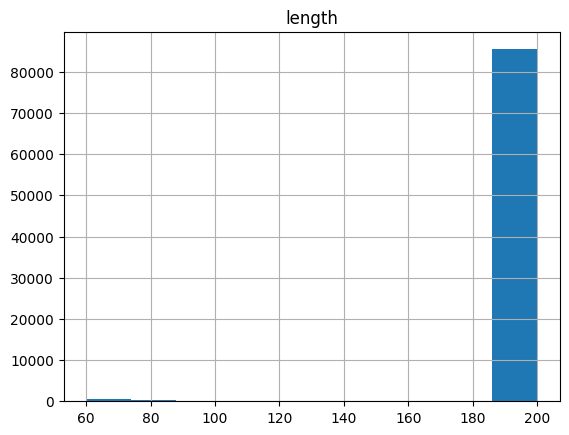

In [24]:
df_seg.hist(column='length')

In [25]:
results = []

# Define threshold: anything > threshold bytes is considered payload data
# I choose 180 because in above histogram, there's a clear seperation, so I think the packet of size less than it may not be a payload
payload_threshold = 180

for ip in netflix_ip:

    sub = df[df['ip_src'] == ip].copy()
    if sub.empty:
        continue

    sub = sub.sort_values('time')

    sub['has_payload'] = sub['length'] > payload_threshold


    segments = 0
    last_zero = True

    for has_payload in sub['has_payload']:
        if not has_payload:
            last_zero = True
        else:
            if last_zero:
                segments += 1
                last_zero = False


    duration = sub['time'].iloc[-1] - sub['time'].iloc[0]
    seg_rate = segments / duration if duration > 0 else 0

    results.append({
        'ip': ip,
        'segments': segments,
        'duration_sec': duration,
        'segments_per_sec': seg_rate
    })


segments_df = pd.DataFrame(results)


print(segments_df)

netflix_features["ip_src"] = netflix_features["flow_id"].str.split("_").str[0]

# Merge with segments_df (joining on destination IP)
merged = netflix_features.merge(
    segments_df[["ip", "segments_per_sec"]],
    left_on="ip_src",
    right_on="ip",
    how="left"
).drop(columns=["ip"])

merged[~merged['segments_per_sec'].isna()].head(5)

                ip  segments duration_sec                  segments_per_sec
0   198.38.120.130         5    17.122323    0.2920164512724120436228191700
1     52.19.39.146        37   430.071491   0.08603220807305267300314960891
2    52.210.19.176         7   127.625420   0.05484800755210051414522279339
3   198.38.120.153        10    13.751028    0.7272183577838689587425754642
4   198.38.120.137         4    67.323224   0.05941486105894156227574603379
5   198.38.120.167         8    14.850794    0.5386917359435461834565882471
6     34.252.77.54         2   480.407859  0.004163129229740598394332262579
7   198.38.120.134         2    60.951867   0.03281277667835835118881592257
8   198.38.120.164        20   475.341855   0.04207498201478596914214507788
9   198.38.120.166       149   475.340378    0.3134595900035237486178798806
10  198.38.120.162         7    75.093257   0.09321742430215804862479197034
11    52.48.148.78         1    26.194976   0.03817525925582065812925348739
12  52.208.1

,flow_id,pkt_count,total_bytes,mean_pkt_size,std_pkt_size,duration,throughput,ip_src,segments_per_sec
55,198.38.120.130_192.168.43.72_443.0_58451.0_TCP,10,1383,138.300000,66.329229,13.725949,100.7580605173456494702114950,198.38.120.130,0.2920164512724120436228191700
56,198.38.120.130_192.168.43.72_443.0_58452.0_TCP,9,1183,131.444444,66.488930,13.727318,86.17852372910717155383156418,198.38.120.130,0.2920164512724120436228191700
57,198.38.120.130_192.168.43.72_443.0_58453.0_TCP,10,1383,138.300000,66.329229,13.724249,100.7705412514739422171661269,198.38.120.130,0.2920164512724120436228191700
58,198.38.120.130_192.168.43.72_443.0_58480.0_TCP,4,272,68.000000,4.000000,16.688559,16.29859114858269069246781583,198.38.120.130,0.2920164512724120436228191700
59,198.38.120.134_192.168.43.72_443.0_58496.0_TCP,69,12946,187.623188,37.506902,60.951867,212.3971034390136072452054668,198.38.120.134,0.03281277667835835118881592257


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [26]:
import pickle
import pandas as pd

df = pd.read_pickle("netflix_dataset.pkl")
print(df.shape)


(52279, 251)


In [27]:
for i in list(df.columns):
    print(i)

10_EWMA_chunksizes
10_avg_chunksize
10_chunksizes_50
10_chunksizes_50R
10_chunksizes_75
10_chunksizes_75R
10_chunksizes_85
10_chunksizes_85R
10_chunksizes_90
10_chunksizes_90R
10_max_chunksize
10_min_chunksize
10_std_chunksize
absolute_timestamp
access_50_perc
access_75_perc
access_avg
access_max
access_min
access_stddev
access_var
ads
all_prev_down_chunk_iat_50
all_prev_down_chunk_iat_50R
all_prev_down_chunk_iat_75
all_prev_down_chunk_iat_75R
all_prev_down_chunk_iat_85
all_prev_down_chunk_iat_85R
all_prev_down_chunk_iat_90
all_prev_down_chunk_iat_90R
all_prev_down_chunk_iat_avg
all_prev_down_chunk_iat_max
all_prev_down_chunk_iat_min
all_prev_down_chunk_iat_std
all_prev_up_chunk_iat_50
all_prev_up_chunk_iat_50R
all_prev_up_chunk_iat_75
all_prev_up_chunk_iat_75R
all_prev_up_chunk_iat_85
all_prev_up_chunk_iat_85R
all_prev_up_chunk_iat_90
all_prev_up_chunk_iat_90R
all_prev_up_chunk_iat_avg
all_prev_up_chunk_iat_max
all_prev_up_chunk_iat_min
all_prev_up_chunk_iat_std
allprev_avg_chunksize


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [28]:
valid_resolution = [240, 360, 480, 720, 1080]

valid_df = df[df['resolution'].isin(valid_resolution)]
original_df = valid_df.copy()
valid_df.shape

(49748, 251)

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [29]:
# I use LLM to help me to understand the meaning of some features since I lack the specific domain knowledge
optimized_drop_cols = [
    # post resolution information
    "quality", "bitrate", "previous_bitrate", "bitrate_change",
    "c_resolution_switches", "n_bitrate_switches", "c_bitrate_switches",
    "service_Video_throughput_down", "service_Video_throughput_up",
    

    # Identifiers / timestamps / meta
    "session_id", "deployment_session_id", "home_id", "video_id",
    "index", "absolute_timestamp", "relative_timestamp",
    "chunk_start_time", "chunk_end_time",
    "service",  # constant in Netflix-only datasets

    # Derived cumulative or sequential indicators
    "cumsum_chunksizes", "cumsum_diff", "avg_flow_age",

    # Startup / initial buffering info
    "startup_time", "startup3.3", "startup5", "startup6.6", "startup10", "startup_mc",

    # Video-specific non-network attributes
    "video_duration", "video_position",

    # Access / wireless / throughput redundancy (keep avg)
    "access_50_perc", "access_75_perc", "access_max", "access_min",
    "access_stddev", "access_var",
    "wireless_50_perc", "wireless_75_perc", "wireless_max", "wireless_min",
    "wireless_stddev", "wireless_var",
    "total_throughput_down", "total_throughput_up",

    # Statistical redundancy (keep _avg and _std)
    "10_EWMA_chunksizes", "10_chunksizes_50", "10_chunksizes_50R",
    "10_chunksizes_75", "10_chunksizes_75R", "10_chunksizes_85",
    "10_chunksizes_85R", "10_chunksizes_90", "10_chunksizes_90R",
    "10_max_chunksize", "10_min_chunksize",
    "allprev_chunksizes_50", "allprev_chunksizes_50R", "allprev_chunksizes_75",
    "allprev_chunksizes_75R", "allprev_chunksizes_85", "allprev_chunksizes_85R",
    "allprev_chunksizes_90", "allprev_chunksizes_90R",
    "allprev_max_chunksize", "allprev_min_chunksize",

    # Server & user TCP flags / rarely informative counters
    "serverAckFlags", "serverPshFlags", "serverRstFlags", "serverSynFlags",
    "serverFinFlags", "serverUrgFlags",
    "userAckFlags", "userPshFlags", "userRstFlags", "userSynFlags",
    "userFinFlags", "userUrgFlags",

    # Packet retransmit details (keep aggregate stats like Avg or Std)
    "serverOneRetransmit", "serverTwoRetransmit", "serverXRetransmit",
    "serverZeroRetransmit", "userOneRetransmit", "userTwoRetransmit",
    "userXRetransmit", "userZeroRetransmit",
]
valid_df = valid_df.drop(columns=[c for c in optimized_drop_cols if c in valid_df.columns])
print(valid_df.shape)

(49748, 166)


**Briefly explain why you removed those columns.**

My general strategy is to move the features that is unique to each row, for example the session_id, chunk_start_time, chunk_end_time, these can uniquely identify a row and lead to overfitting.

Then I will remove some columns that has very high correlation, for example, (access_stddev, access_var) the access_seddev can be perfectly derived from access_var so I will drop the seddev. 

Finally, LLM suggest me to remove some post resolution information, which means these information may not be collected without knowing the resolution beforehand. 

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [30]:
from sklearn.model_selection import train_test_split
X = valid_df.copy().drop(columns = 'resolution')
Y = valid_df['resolution']
print(X.shape)
print(Y.shape)

(49748, 165)
(49748,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
Y = le.fit_transform(Y)
X_train, X_rest, y_train, y_rest = train_test_split(
    X, Y, test_size=0.2, random_state=1000, stratify=Y
)

# split the rest data to validation set and test set
# the overall speration is of 8:1:1
X_val, X_test, y_val, y_test = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=1000, stratify= y_rest
)

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [32]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# I choose a gradientboosting tree as the model since these type of model usually perform great on tabular data

baseline_model = XGBClassifier(
    tree_method='hist',
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.05,
)

baseline_model.fit(X_train, y_train)

y_pred_base = baseline_model.predict(X_val)
acc_base = accuracy_score(y_val, y_pred_base)

print(f"Baseline Accuracy: {acc_base:.4f}")




Baseline Accuracy: 0.9110


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [34]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [6, 12, 20],
    'learning_rate': [0.05, 0.1, 0.5],
}


grid_search = GridSearchCV(
    estimator= baseline_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=3,
)

# use the training and validation set for cross validation
X_tune = np.vstack([X_train, X_val])
y_tune = np.hstack([y_train, y_val])
grid_search.fit(X_tune, y_tune)
best_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=6;, score=0.911 total time=   3.9s
[CV 2/3] END ...learning_rate=0.05, max_depth=6;, score=0.910 total time=   3.8s
[CV 3/3] END ...learning_rate=0.05, max_depth=6;, score=0.911 total time=   3.8s
[CV 1/3] END ..learning_rate=0.05, max_depth=12;, score=0.940 total time=  15.3s
[CV 2/3] END ..learning_rate=0.05, max_depth=12;, score=0.938 total time=  15.1s
[CV 3/3] END ..learning_rate=0.05, max_depth=12;, score=0.940 total time=  15.2s
[CV 1/3] END ..learning_rate=0.05, max_depth=20;, score=0.941 total time=  26.0s
[CV 2/3] END ..learning_rate=0.05, max_depth=20;, score=0.940 total time=  25.7s
[CV 3/3] END ..learning_rate=0.05, max_depth=20;, score=0.941 total time=  25.3s
[CV 1/3] END ....learning_rate=0.1, max_depth=6;, score=0.929 total time=   3.8s
[CV 2/3] END ....learning_rate=0.1, max_depth=6;, score=0.927 total time=   4.0s
[CV 3/3] END ....learning_rate=0.1, max_depth=6;,

### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

In [36]:
# evaluate the model performance on the testset.
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

try:
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
except:
    auc = None

print(f"\nAccuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

print(f"ROC AUC: {auc:.4f}")
print("\nConfusion Matrix:\n", cm)



Accuracy: 0.9526
F1 Score: 0.9519
ROC AUC: 0.9943

Confusion Matrix:
 [[ 128   12   27    3    0]
 [  13  369   55   10    0]
 [  14   23 2895   15    2]
 [   5    1   41  891    8]
 [   0    0    0    7  456]]


## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

In [ ]:
'''
due to the random nature of train-test split, the test set didn't have continuous time, 
so I think the plot is not informative. I just showed the predicted resolution for each sample.
'''
y_pred = best_model.predict(X_test)
y_pred[y_pred == 0] = 240
y_pred[y_pred == 1] = 360
y_pred[y_pred == 2] = 480
y_pred[y_pred == 3] = 720
y_pred[y_pred == 4] = 1080
print(y_pred)
full_data = np.hstack([X_test, y_pred.reshape(-1,1)])
print(full_data)

[360 360 480 ... 480 480 480]


[[139861.6 35492.024206010006 0.0 ... 0 0.0 360]
 [145798.6 71671.2342410817 0.0 ... 0 0.0 360]
 [900224.3 363852.6975060237 0.0 ... 0 0.0 480]
 ...
 [632708.4 257926.5418599645 21.9974859 ... 0 0.0 480]
 [416141.0 134155.5588777446 0.0 ... 0 0.0 480]
 [729051.2 321686.75096397736 0.0 ... 0 0.0 480]]
